In [1]:
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import StratifiedKFold

split_num = 10


# data input 
path = 'trainrat_new.txt'
data = pd.read_csv(path,sep=' ')
print(len(data))

# Data extraction,Win
win_data = data[data.label == "W"]
win_data = win_data.assign(W=1,D=0,L=0) 
win_data = win_data.drop("label",axis=1)
win_data = win_data.sample(n=len(win_data))# random sort

# Data extraction,Draw
draw_data = data[data.label == "D"]
draw_data = draw_data.assign(W=0,D=1,L=0)
draw_data = draw_data.drop("label",axis=1)
draw_data = draw_data.sample(n=len(draw_data))# random sort

# Data extraction,Lose
lose_data = data[data.label == "L"]
lose_data = lose_data.assign(W=0,D=0,L=1) 
lose_data = lose_data.drop("label",axis=1)
lose_data = lose_data.sample(n=len(lose_data))# random sort

# Group data together,use for normal k-fold
all_data = pd.concat([win_data, draw_data, lose_data])
all_data = all_data.sample(n=len(all_data))# random sort
#yAll = xAll[["W","D","L"]]

# Data drop
#xWin = xWin.drop(["W","D","L"],axis=1)
#xDraw = xDraw.drop(["W","D","L"],axis=1)
#xLose = xLose.drop(["W","D","L"],axis=1)
#xAll = xAll.drop(["W","D","L"],axis=1)

# Data separate and making dataset
win_data_separate = []
draw_data_separate = []
lose_data_separate = []
all_data_separate = []
wdl_separate = []
for i in range(split_num):
    win_data_separate.append(win_data[i::split_num])
    draw_data_separate.append(draw_data[i::split_num])
    lose_data_separate.append(lose_data[i::split_num])
    all_data_separate.append(all_data[i::split_num])
    # merge for stratified sampling
    wdl_separate.append(pd.concat([win_data_separate[i],draw_data_separate[i],lose_data_separate[i]]))
    # assign a number to make final input data
    wdl_separate[i] = wdl_separate[i].assign(separate_num=i)
    all_data_separate[i] = all_data_separate[i].assign(separate_num=i)

# integrate everything once
wdl_separate_merge = wdl_separate[0]
all_data_separate_merge = all_data_separate[0]
for i in range(1,split_num):
    wdl_separate_merge = wdl_separate_merge.append(wdl_separate[i])
    all_data_separate_merge = all_data_separate_merge.append(all_data_separate[i])

#print(len(wdl_separate_merge))
#print(len(all_data_separate_merge))
    
    
# make final input data
x_train = []
y_train = []
x_val = []
y_val = []
xAll_train = []
yAll_train = []
xAll_val = []
yAll_val = []
for i in range(split_num):
    x_train.append(wdl_separate_merge[wdl_separate_merge['separate_num'] != i])
    x_val.append(wdl_separate_merge[wdl_separate_merge['separate_num'] == i])
    xAll_train.append(all_data_separate_merge[all_data_separate_merge['separate_num'] != i])
    xAll_val.append(all_data_separate_merge[all_data_separate_merge['separate_num'] == i])
for i in range(split_num):
    # delete separate_num
    x_train[i] = x_train[i].drop(['separate_num'],axis=1)
    x_val[i] = x_val[i].drop(['separate_num'],axis=1)
    xAll_train[i] = xAll_train[i].drop(['separate_num'],axis=1)
    xAll_val[i] = xAll_val[i].drop(['separate_num'],axis=1)
    # random sort
    x_train[i] = x_train[i].sample(n=len(x_train[i]))
    x_val[i] = x_val[i].sample(n=len(x_val[i]))
    xAll_train[i] = xAll_train[i].sample(n=len(xAll_train[i]))
    xAll_val[i] = xAll_val[i].sample(n=len(xAll_val[i]))
    
    # separate x and y
    y_train.append(x_train[i][["W","D","L"]])
    y_val.append(x_val[i][["W","D","L"]])
    yAll_train.append(xAll_train[i][["W","D","L"]])
    yAll_val.append(xAll_val[i][["W","D","L"]])
    x_train[i] = x_train[i].drop(["W","D","L"],axis=1)
    x_val[i] = x_val[i].drop(["W","D","L"],axis=1)
    xAll_train[i] = xAll_train[i].drop(["W","D","L"],axis=1)
    xAll_val[i] = xAll_val[i].drop(["W","D","L"],axis=1)
    
    #translate pandas to numpy
    x_train[i] = x_train[i].values.astype('float32') 
    x_val[i] = x_val[i].values.astype('float32') 
    y_train[i] = y_train[i].values
    y_val[i] = y_val[i].values


28186


In [2]:
def RPS(y_true, y_pred):
    output = 0.
    data_num = len(y_true)
    for i in range(data_num):
        times = len(y_true[i]) - 1 
        cumulative_sum = 0.
        score = 0.
        for time in range(times):
            cumulative_sum += y_true[i,time] - y_pred[i,time]
            score += cumulative_sum ** 2
        score /= times
        output += score
    
    output /= data_num
    return output


In [12]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Sequential, cuda
import time

# craete model
# net としてインスタンス化
n_input = 8
n_hidden = 10
n_output = 3

gpu_device = 0
cuda.get_device(gpu_device).use()
xp = cuda.cupy


# create 10 model for 10-fold-crossvalidation?
optimizer = []
net = []

for i in range(10):
    net.append(Sequential(
        L.Linear(n_input, n_hidden), F.relu,
        L.Linear(n_hidden, n_hidden), F.relu,
        L.Linear(n_hidden, n_hidden), F.relu,
        L.Linear(n_hidden, n_output), F.softmax)
    )
    optimizer.append(chainer.optimizers.Adam(alpha=0.0001))
    optimizer[i].setup(net[i])
    net[i].to_gpu(gpu_device)
    



In [15]:
import numpy as np
#print(np.random.permutation(range(len(x_train))))
n_epoch = 2
batchsize = 16
# ログの保存用
results_train_data = []
results_valid_data = []

start = time.time()

x_train = cuda.to_gpu(x_train)
y_train = cuda.to_gpu(y_train)
x_val = cuda.to_gpu(x_val)
y_val = cuda.to_gpu(y_val)
for data_num in range(len(x_train)):
    # ログの保存用
    results_train = {
        'loss': [],
        'accuracy': []
    }
    results_valid = {
        'loss': [],
        'accuracy': []
    }
    iteration = 0
    for epoch in range(n_epoch):
        # 各バッチ毎の目的関数の出力と分類精度の保存用
        loss_list = []
        #accuracy_list = []

        for i in range(0, len(x_train[data_num]), batchsize):
            # バッチを準備
            x_train_batch = x_train[data_num][i:i+batchsize,:]
            y_train_batch = y_train[data_num][i:i+batchsize,:]

            # 予測値を出力
            y_train_batch_pred = net[data_num](x_train_batch)
            # 目的関数を適用し、分類精度を計算
            loss_train_batch = RPS(y_train_batch, y_train_batch_pred)
            #print(loss_train_batch)
            #accuracy_train_batch = F.accuracy(y_train_batch_pred, y_train_batch)

            loss_list.append(loss_train_batch.array)
            #accuracy_list.append(accuracy_train_batch.array)

            # 勾配のリセットと勾配の計算
            net[data_num].cleargrads()
            loss_train_batch.backward()

            # パラメータの更新
            optimizer[data_num].update()

            # カウントアップ
            iteration += 1

        loss_list = np.array(loss_list,dtype=np.float32)
        # 訓練データに対する目的関数の出力と分類精度を集計
        loss_train = np.mean(loss_list)
        #accuracy_train = np.mean(accuracy_list)

        # 1エポック終えたら、検証データで評価
        # 検証データで予測値を出力
        with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
            y_val_pred = net[data_num](x_val[data_num])

        #print(y_val)
        # 目的関数を適用し、分類精度を計算
        loss_val = RPS(y_val_pred, y_val[data_num])
        #accuracy_val = F.accuracy(y_val_pred, y_val[data_num])

        # 結果の表示
        print('epoch: {}, iteration: {}, loss (train): {}, loss (valid): {}'.format(
            epoch, iteration, loss_train, loss_val.array))

        # ログを保存
        results_train['loss'].append(loss_train)
        #results_train['accuracy'] .append(accuracy_train)
        results_valid['loss'].append(loss_val.array)
        #results_valid['accuracy'].append(accuracy_val.array)
        
    results_train_data.append(results_train)
    results_valid_data.append(results_valid)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


epoch: 0, iteration: 1586, loss (train): 0.20835481584072113, loss (valid): 0.20786996
epoch: 1, iteration: 3172, loss (train): 0.20833124220371246, loss (valid): 0.20787336
epoch: 0, iteration: 1586, loss (train): 0.22374379634857178, loss (valid): 0.21821304
epoch: 1, iteration: 3172, loss (train): 0.21811813116073608, loss (valid): 0.21509016
epoch: 0, iteration: 1586, loss (train): 0.22561538219451904, loss (valid): 0.2194577
epoch: 1, iteration: 3172, loss (train): 0.21576562523841858, loss (valid): 0.21423094
epoch: 0, iteration: 1586, loss (train): 0.22669461369514465, loss (valid): 0.21711928
epoch: 1, iteration: 3172, loss (train): 0.21341022849082947, loss (valid): 0.21057877
epoch: 0, iteration: 1586, loss (train): 0.22403673827648163, loss (valid): 0.21843708
epoch: 1, iteration: 3172, loss (train): 0.2154153436422348, loss (valid): 0.21302739
epoch: 0, iteration: 1586, loss (train): 0.2235424518585205, loss (valid): 0.2160121
epoch: 1, iteration: 3172, loss (train): 0.2147

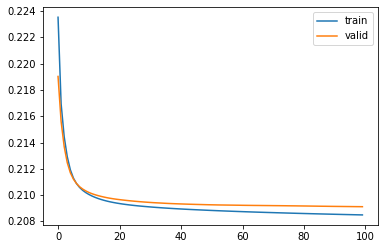

In [7]:

import matplotlib.pyplot as plt
results_train_data_all = []
results_valid_data_all = []
results_train_data_all = np.zeros(epoch+1)
results_valid_data_all = np.zeros(epoch+1)
# 目的関数の出力 (loss)
for i in range(split_num):   
    results_train_data_all += results_train_data[i]['loss']
    results_valid_data_all += results_valid_data[i]['loss']
    #plt.plot(results_train_data[i]['loss'], label='train')  # label で凡例の設定
    #plt.plot(results_valid_data[i]['loss'], label='valid')  # label で凡例の設定
    #plt.legend()  # 凡例の表示
    #plt.figure()

plt.plot(results_train_data_all / 10, label='train')  # label で凡例の設定
plt.plot(results_valid_data_all / 10, label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示


In [8]:
print(results_train_data_all)
print(results_valid_data_all)

[2.23535322 2.16941769 2.14440741 2.12920447 2.11931248 2.11298235
 2.1088088  2.1058611  2.10366723 2.1019666  2.10055968 2.09937321
 2.09835178 2.09745985 2.09669174 2.09601137 2.09540942 2.0948773
 2.09440427 2.09397469 2.09359266 2.09323308 2.0929094  2.09261194
 2.0923346  2.09207983 2.09183899 2.09161651 2.09140769 2.09120737
 2.09101495 2.09082516 2.09064701 2.09048007 2.09031411 2.09015957
 2.09001017 2.08986399 2.08972245 2.08958869 2.08945775 2.08932942
 2.0892092  2.08908944 2.08897673 2.08886774 2.08876173 2.08865374
 2.0885479  2.088443   2.08834404 2.08824261 2.08814463 2.08805083
 2.0879567  2.08786845 2.08778144 2.08769353 2.08760576 2.08752215
 2.0874356  2.087355   2.08727506 2.08719376 2.08711712 2.08704042
 2.08696543 2.08689326 2.08682288 2.08675259 2.08668332 2.08661352
 2.08654399 2.08647634 2.08640859 2.08633997 2.08627218 2.08620565
 2.08614154 2.0860807  2.08601677 2.08595604 2.08589441 2.08583617
 2.08577661 2.08571735 2.0856587  2.08560114 2.08554475 2.08548